In [1]:
!pip install sparqlwrapper

In [2]:
from SPARQLWrapper import SPARQLWrapper, JSON

sparqlendpoint = SPARQLWrapper(
    "https://nanosafety.rdf.bigcat-bioinformatics.org/sparql"
)

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import pandas as pd

# Usefull dataframes

### Df to map material kinds to colors

In [5]:
kinds = ['Titanium dioxide', 'Silver containing NMs', 'Silica particles', 'Other metal (oxide) NMs','Other carbon based NMs','Carbon nanotubes']
colors = ['#f27360', '#f3c766','#9aaaba', '#9fc2bb','#bcbdc1', '#485868']

zipped = list(zip(kinds, colors))

df_c = pd.DataFrame(zipped, columns=['kind', 'color'])
df_c

,kind,color
0,Titanium dioxide,#f27360
1,Silver containing NMs,#f3c766
2,Silica particles,#9aaaba
3,Other metal (oxide) NMs,#9fc2bb
4,Other carbon based NMs,#bcbdc1
5,Carbon nanotubes,#485868


In [6]:
more_colors = ['#6e6f71', '#f27360', '#f3c766','#9aaaba', '#9fc2bb','#bcbdc1', '#485868', '#fbe6e1', '#f5a46c']

# Figure 3

In [7]:
sparqlquery = '''
PREFIX dcterms: <http://purl.org/dc/terms/>
PREFIX obo: <http://purl.obolibrary.org/obo/>

select distinct ?materialtype (count(distinct ?ID AS ?Number)) (GROUP_CONCAT(distinct ?materialname;SEPARATOR=", ") AS ?materialnames)  (GROUP_CONCAT(distinct ?ID;SEPARATOR=", ") AS ?ERMs) where { 
    ?s a obo:CHEBI_59999; 
    dcterms:identifier ?ID ; 
    dcterms:title ?materialname ; 
    dcterms:type ?materialtype ; 
    dcterms:source ?source.
} 
'''

sparqlendpoint.setQuery(sparqlquery)
sparqlendpoint.setReturnFormat(JSON)  
results = sparqlendpoint.query().convert()

df = pd.DataFrame(columns=["type","Number","Names","ERMs"])
for result in results["results"]["bindings"]:
    df.loc[len(df.index)] = [result["materialtype"]["value"],
                             int(result["callret-1"]["value"]),
                             result["materialnames"]["value"],
                             result["ERMs"]["value"]
                            ]

display(df.head(10))

,type,Number,Names,ERMs
0,http://purl.enanomapper.org/onto/ENM_0000123,1,samarium oxide nanoparticle,https://nanocommons.github.io/identifiers/regi...
1,http://purl.bioontology.org/ontology/npo#NPO_1550,1,Fe2O3 nanoparticle,https://nanocommons.github.io/identifiers/regi...
2,http://purl.enanomapper.org/onto/ENM_9000205,1,zinc oxide nanoparticle NM110,https://nanocommons.github.io/identifiers/regi...
3,http://purl.bioontology.org/ontology/npo#NPO_354,13,"multi-walled carbon nanotubes, multi-walled ca...",https://nanocommons.github.io/identifiers/regi...
4,http://purl.enanomapper.org/onto/ENM_0000120,1,yttrium oxide nanoparticle,https://nanocommons.github.io/identifiers/regi...
5,http://purl.obolibrary.org/obo/CHEBI_134404,2,graphene,https://nanocommons.github.io/identifiers/regi...
6,http://purl.enanomapper.org/onto/ENM_0000126,1,erbium oxide nanoparticle,https://nanocommons.github.io/identifiers/regi...
7,http://purl.bioontology.org/ontology/npo#NPO_1486,9,titanium dioxide nanoparticle,https://nanocommons.github.io/identifiers/regi...
8,http://purl.enanomapper.org/onto/ENM_9000227,1,cerium oxide NM212,https://nanocommons.github.io/identifiers/regi...
9,http://purl.enanomapper.org/onto/ENM_0000124,2,gadolinium oxide nanoparticle,https://nanocommons.github.io/identifiers/regi...


In [8]:
df[df.Names.str.contains('microparticle|macroparticle')]

,type,Number,Names,ERMs
16,http://purl.obolibrary.org/obo/CHEBI_36560,1,zinc oxide microparticle,https://nanocommons.github.io/identifiers/regi...
22,http://purl.obolibrary.org/obo/CHEBI_33964,2,silver microparticle,https://nanocommons.github.io/identifiers/regi...
27,http://purl.obolibrary.org/obo/CHEBI_23377,1,copper macroparticle,https://nanocommons.github.io/identifiers/regi...


In [9]:
df2 = df.copy()
df2['kind'] = 'Other metal (oxide) NMs'

df2.loc[df2[df2.Names.str.contains('nanotube')].index,'kind'] = 'Carbon nanotubes'
df2.loc[df2[df2.Names.str.contains('printex|fullerene|graphene')].index,'kind'] = 'Other carbon based NMs'
df2.loc[df2[df2.Names.str.contains('titanium')].index,'kind'] = 'Titanium dioxide'
df2.loc[df2[df2.Names.str.contains('silver')].index,'kind'] = 'Silver containing NMs'
df2.loc[df2[df2.Names.str.contains('silica')].index,'kind'] = 'Silica particles'

df2 = df2.merge(df_c)

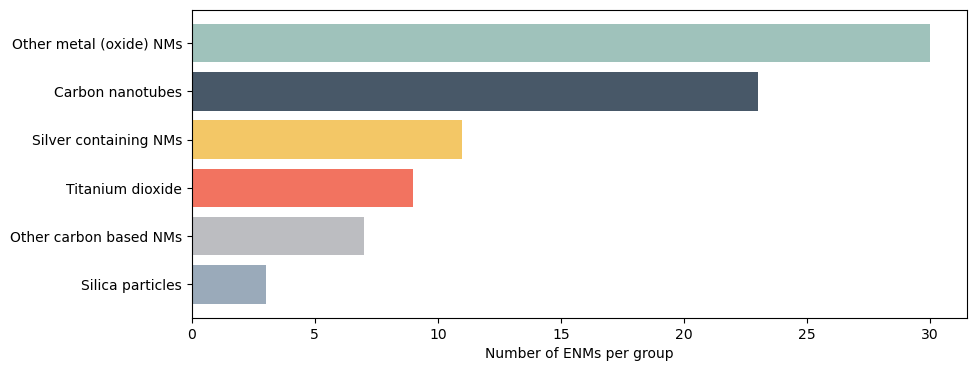

In [10]:
df_count_all = pd.DataFrame(df2[~df2.Names.str.contains("microparticle|macroparticle")].groupby(['kind', 'color']).Number.sum()).reset_index().sort_values(by=["Number"],ascending=True,ignore_index=True)

plt.figure(figsize=(10,4))
plt.barh(df_count_all.kind, df_count_all.Number, color = df_count_all.color)
plt.rc('font', size=14) 
plt.xlabel("Number of ENMs per group")
plt.show()

# Figure 4

In [11]:
sparqlquery = '''
PREFIX dcterms: <http://purl.org/dc/terms/>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX obo: <http://purl.obolibrary.org/obo/>
PREFIX sio: <http://semanticscience.org/resource/>

SELECT DISTINCT ?mie (COUNT (DISTINCT ?ID AS ?n)) (GROUP_CONCAT(DISTINCT ?mietitle;SEPARATOR=", ") AS ?mietitles) (GROUP_CONCAT(DISTINCT ?ID;SEPARATOR=", ") AS ?ERMs) 
WHERE { 
    ?s a obo:CHEBI_59999; 
    dcterms:identifier ?ID ; 
    dcterms:title ?materialname ; 
    sio:SIO_000636 ?mie .
  FILTER (!regex(?materialname, "microparticle|macroparticle", "i"))
  SERVICE <https://aopwiki.rdf.bigcat-bioinformatics.org/sparql> {
    ?mie dc:title ?mietitle .
  }}
'''

sparqlendpoint.setQuery(sparqlquery)
sparqlendpoint.setReturnFormat(JSON)  
results = sparqlendpoint.query().convert()

df = pd.DataFrame(columns=["MIE","Count","MIETitles", "ERMS"])
for result in results["results"]["bindings"]:
    # print(result)
    df.loc[len(df.index)] = [result["mie"]["value"],
                             int(result["callret-1"]["value"]),
                             result["mietitles"]["value"],
                             result["ERMs"]["value"]
                            ]
df = df.drop_duplicates(subset=['ERMS'])
df['[perc'] = df.Count/df.Count.sum()*100  

df.sort_values(by=["MIETitles"],ascending=False,ignore_index=True)

display(df)

,MIE,Count,MIETitles,ERMS,[perc
0,https://identifiers.org/aop.events/396,3,"Covalent Binding, Protein",https://nanocommons.github.io/identifiers/regi...,4.285714
1,https://identifiers.org/aop.events/478,19,"Activation, NRF2",https://nanocommons.github.io/identifiers/regi...,27.142857
2,https://identifiers.org/aop.events/1592,23,ROS generation from photoactivated chemicals,https://nanocommons.github.io/identifiers/regi...,32.857143
3,https://identifiers.org/aop.events/1529,2,"Blockade, L-Type Calcium Channels",https://nanocommons.github.io/identifiers/regi...,2.857143
4,https://identifiers.org/aop.events/1495,3,Substance interaction with the lung resident c...,https://nanocommons.github.io/identifiers/regi...,4.285714
5,https://identifiers.org/aop.events/177,1,"N/A, Mitochondrial dysfunction 1",https://nanocommons.github.io/identifiers/regi...,1.428571
7,https://identifiers.org/aop.events/1194,17,"Increase, DNA damage",https://nanocommons.github.io/identifiers/regi...,24.285714
8,https://identifiers.org/aop.events/1502,2,Histone deacetylase inhibition,https://nanocommons.github.io/identifiers/regi...,2.857143


In [12]:
df[df.MIETitles.str.contains("interaction")].MIETitles.iloc[0]

'Substance interaction with the lung resident cell membrane components'

In [13]:
df.loc[4,'MIETitles'] = "Substance interaction with the lung-\n resident cell membrane components"

In [14]:
unique_erms = set()

for erms in df.ERMS.tolist():
    for erm in erms.split(','):
        unique_erms.add(erm)

len(unique_erms)

53

In [15]:
DNA_list = []
for erm in df[df.MIETitles.str.contains("DNA")].ERMS.iloc[0].split(','):
    DNA_list.append(erm.split('00000')[1])

In [16]:
ROS_list = []
for erm in df[df.MIETitles.str.contains("ROS")].ERMS.iloc[0].split(','):
    ROS_list.append(erm.split('00000')[1])

In [17]:
NRf2_list = []
for erm in df[df.MIETitles.str.contains("NRF2")].ERMS.iloc[0].split(','):
    NRf2_list.append(erm.split('00000')[1])

<AxesSubplot: >

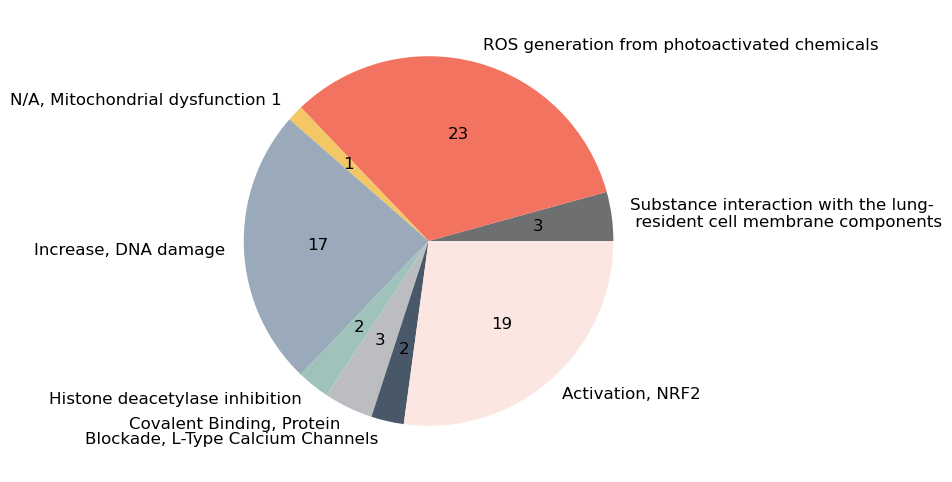

In [18]:
total=df.Count.sum()

def ERM_Count(x):
    return '{:.0f}'.format(total*x/100)

df= df.sort_values(by=["MIETitles"],ascending=False,ignore_index=True)

df.plot.pie(y='Count', colors = more_colors, labels=df.MIETitles, figsize=(6, 6), legend=False, ylabel='', autopct=ERM_Count, textprops={'fontsize': 12})

# Query measurements

In [19]:
sparqlquery = '''
PREFIX obo: <http://purl.obolibrary.org/obo/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX bao: <http://www.bioassayontology.org/bao#>
PREFIX sio: <http://semanticscience.org/resource/>
PREFIX dcterms: <http://purl.org/dc/terms/>

select distinct ?measurement (count (distinct ?ID AS ?n)) where {
values(?p){(sio:has-value) (obo:STATO_0000035)}
?s a obo:CHEBI_59999;
dcterms:identifier ?ID ;
dcterms:title ?materialname ; 
obo:BFO_0000056 ?mg .
FILTER (!regex(?materialname, "microparticle|macroparticle", "i"))
?mg bao:BAO_0000208 ?o .
?o a bao:BAO_0000179 ;
?p ?val ;
rdfs:label ?measurement .
}
'''

sparqlendpoint.setQuery(sparqlquery)
sparqlendpoint.setReturnFormat(JSON)  
results = sparqlendpoint.query().convert()

df = pd.DataFrame(columns=["Shape","Count"])
for result in results["results"]["bindings"]:
    df.loc[len(df.index)] = [result["measurement"]["value"],
                             int(result["callret-1"]["value"])
                            ]
    
df['perc'] = df.Count/83*100    

display(df.sort_values(by=["perc"],ascending=False,ignore_index=True))

,Shape,Count,perc
0,shape,65,78.313253
1,hydrodynamic diameter,62,74.698795
2,zeta potential,58,69.879518
3,primary size,58,69.879518
4,diameter,22,26.506024
5,specific surface area,16,19.277108
6,bundle diameter,8,9.638554


# Query shapes

In [20]:
sparqlquery = '''
PREFIX obo: <http://purl.obolibrary.org/obo/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX bao: <http://www.bioassayontology.org/bao#>
PREFIX sio: <http://semanticscience.org/resource/>
PREFIX dcterms: <http://purl.org/dc/terms/>

select distinct ?val (count (distinct ?ID AS ?n)) (GROUP_CONCAT(distinct ?ID;SEPARATOR=", ") AS ?ERMs) where {
values(?p){(sio:has-value) (obo:STATO_0000035)}
?s a obo:CHEBI_59999;
dcterms:identifier ?ID ;
dcterms:title ?materialname ; 
obo:BFO_0000056 ?mg .
FILTER (!regex(?materialname, "microparticle|macroparticle", "i"))
?mg bao:BAO_0000208 ?o .
?o a bao:BAO_0000179 ;
?p ?val ;
rdfs:label ?measurement ;
rdfs:label "shape"@en .
}
'''

sparqlendpoint.setQuery(sparqlquery)
sparqlendpoint.setReturnFormat(JSON)  
results = sparqlendpoint.query().convert()

df = pd.DataFrame(columns=["Shape","Count","ERMs"])
for result in results["results"]["bindings"]:
    df.loc[len(df.index)] = [result["val"]["value"],
                             int(result["callret-1"]["value"]),
                             result["ERMs"]["value"]
                            ]
display(df)

,Shape,Count,ERMs
0,sheet,5,https://nanocommons.github.io/identifiers/regi...
1,spherical,37,https://nanocommons.github.io/identifiers/regi...
2,tube,21,https://nanocommons.github.io/identifiers/regi...
3,plate,1,https://nanocommons.github.io/identifiers/regi...
4,cube,1,https://nanocommons.github.io/identifiers/regi...


# Table 3

In [21]:
sparqlquery1 = '''
PREFIX obo: <http://purl.obolibrary.org/obo/>
PREFIX dcterms: <http://purl.org/dc/terms/>
PREFIX bao: <http://www.bioassayontology.org/bao#>
PREFIX sio: <http://semanticscience.org/resource/>

select distinct ?measurement (count (distinct ?ID) AS ?nERMs) (MIN(?val) as ?MinVal) (MAX(?val) as ?MaxVal) (AVG(?val) as ?AvgVal) where {
values(?p){(sio:has-value) (obo:STATO_0000035)}
?s a obo:CHEBI_59999;
dcterms:identifier ?ID ;
dcterms:title ?materialname ; 
obo:BFO_0000056 ?mg .
FILTER (!regex(?materialname, "microparticle|macroparticle", "i"))
?mg bao:BAO_0000208 ?o .
?o2 bao:BAO_0095000 ?o ;
?p ?val ;
rdfs:label ?measurement .
}
'''

sparqlquery2 = '''
PREFIX obo: <http://purl.obolibrary.org/obo/>
PREFIX dcterms: <http://purl.org/dc/terms/>
PREFIX bao: <http://www.bioassayontology.org/bao#>
PREFIX sio: <http://semanticscience.org/resource/>
PREFIX amb: <http://purl.enanomapper.net/>

select distinct ?measurement ?medium (count (distinct ?ID AS ?nERMs)) (MIN(?val) as ?MinVal) (MAX(?val) as ?MaxVal) (AVG(?val) as ?AvgVal) where {
values(?p){(sio:has-value) (obo:STATO_0000035)}
?s a obo:CHEBI_59999;
dcterms:identifier ?ID ;
dcterms:title ?materialname ; 
obo:BFO_0000056 ?mg .
FILTER (!regex(?materialname, "microparticle|macroparticle", "i"))
?mg bao:BAO_0000208 ?o .
?o2 bao:BAO_0095000 ?o ;
?p ?val ;
rdfs:label ?measurement ;
rdfs:label "normalized zeta potential"@en .
OPTIONAL{?o amb:has-condition ?g .}
OPTIONAL{?g rdfs:label ?medlabel ;
sio:has-value ?medium .}
FILTER CONTAINS(?medium, "water")
}
'''

sparqlquery3 = '''
PREFIX obo: <http://purl.obolibrary.org/obo/>
PREFIX dcterms: <http://purl.org/dc/terms/>
PREFIX bao: <http://www.bioassayontology.org/bao#>
PREFIX sio: <http://semanticscience.org/resource/>
PREFIX amb: <http://purl.enanomapper.net/>

select distinct ?measurement ?medium (count (distinct ?ID AS ?nERMs)) (MIN(?val) as ?MinVal) (MAX(?val) as ?MaxVal) (AVG(?val) as ?AvgVal) where {
values(?p){(sio:has-value) (obo:STATO_0000035)}
?s a obo:CHEBI_59999;
dcterms:identifier ?ID ;
dcterms:title ?materialname ; 
obo:BFO_0000056 ?mg .
FILTER (!regex(?materialname, "microparticle|macroparticle", "i"))
?mg bao:BAO_0000208 ?o .
?o2 bao:BAO_0095000 ?o ;
?p ?val ;
rdfs:label ?measurement ;
rdfs:label "normalized hydrodynamic diameter"@en .
OPTIONAL{?o amb:has-condition ?g .}
OPTIONAL{?g rdfs:label ?medlabel ;
sio:has-value ?medium .}
FILTER CONTAINS(?medium, "water")
}
'''

sparqlendpoint.setQuery(sparqlquery1)
sparqlendpoint.setReturnFormat(JSON)  
results1 = sparqlendpoint.query().convert()

sparqlendpoint.setQuery(sparqlquery2)
sparqlendpoint.setReturnFormat(JSON)  
results2 = sparqlendpoint.query().convert()

sparqlendpoint.setQuery(sparqlquery3)
sparqlendpoint.setReturnFormat(JSON)  
results3 = sparqlendpoint.query().convert()

df = pd.DataFrame(columns=["Measurement","Medium","ERMs","Min", "Max", "Average"])
for result in results1["results"]["bindings"]:
    df.loc[len(df.index)] = [result["measurement"]["value"],
                             "all",
                             int(result["nERMs"]["value"]),
                             float(result["MinVal"]["value"]),
                             float(result["MaxVal"]["value"]),
                             float(result["AvgVal"]["value"])]
    
for result in results2["results"]["bindings"]:
    df.loc[len(df.index)] = [result["measurement"]["value"],
                             result["medium"]["value"],
                             int(result["callret-2"]["value"]),
                             float(result["MinVal"]["value"]),
                             float(result["MaxVal"]["value"]),
                             float(result["AvgVal"]["value"])]
    
for result in results3["results"]["bindings"]:
    df.loc[len(df.index)] = [result["measurement"]["value"],
                             result["medium"]["value"],
                             int(result["callret-2"]["value"]),
                             float(result["MinVal"]["value"]),
                             float(result["MaxVal"]["value"]),
                             float(result["AvgVal"]["value"])]

display(df.sort_values(by=["Measurement"],ascending=False,ignore_index=True))

,Measurement,Medium,ERMs,Min,Max,Average
0,normalized zeta potential,all,58,-46.97,17.0,-11.518246
1,normalized zeta potential,water,37,-39.90,17.0,-14.479879
2,normalized surface area,all,16,6.92,316.5,102.357402
3,normalized primary size,all,58,4.60,5730.0,229.692775
4,normalized hydrodynamic diameter,all,62,9.00,3431.7,385.516682
5,normalized hydrodynamic diameter,water,32,55.20,2007.8,646.288212
6,normalized diameter,all,22,0.83,1676.6,169.051782
7,normalized bundle diameter,all,8,5.00,13.0,8.360000


# Figure 5

In [22]:
sparqlquery = '''
PREFIX obo: <http://purl.obolibrary.org/obo/>
PREFIX dcterms: <http://purl.org/dc/terms/>
PREFIX bao: <http://www.bioassayontology.org/bao#>
PREFIX sio: <http://semanticscience.org/resource/>
PREFIX amb: <http://purl.enanomapper.net/>

select distinct ?measurement ?ID ?val ?materialname where {
values(?p){(sio:has-value) (obo:STATO_0000035)}
?s a obo:CHEBI_59999;
    dcterms:identifier ?ID ;
    dcterms:title ?materialname ; 
    obo:BFO_0000056 ?mg .
FILTER (!regex(?materialname, "microparticle|macroparticle", "i"))
?mg bao:BAO_0000208 ?o .
?o2 bao:BAO_0095000 ?o ;
    ?p ?val ;
    rdfs:label ?measurement ;
    rdfs:label "normalized primary size"@en .
}
'''

sparqlendpoint.setQuery(sparqlquery)
sparqlendpoint.setReturnFormat(JSON)  
results1 = sparqlendpoint.query().convert()

df_pz = pd.DataFrame(columns=["Measurement","ERM","Value","Names"])
for result in results1["results"]["bindings"]:
    df_pz.loc[len(df_pz.index)] = [result["measurement"]["value"],
                             result["ID"]["value"],
                             float(result["val"]["value"]),
                                  result["materialname"]["value"]]
    
df_pz[['url', 'erm']] = df_pz['ERM'].str.split('00000', 1, expand=True)

display(df_pz.head(10))

/tmp/ipykernel_1864002/3537210004.py:34: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  df_pz[['url', 'erm']] = df_pz['ERM'].str.split('00000', 1, expand=True)


,Measurement,ERM,Value,Names,url,erm
0,normalized primary size,https://nanocommons.github.io/identifiers/regi...,3860.00,multi-walled carbon nanotubes,https://nanocommons.github.io/identifiers/regi...,099
1,normalized primary size,https://nanocommons.github.io/identifiers/regi...,97.55,erbium oxide nanoparticle,https://nanocommons.github.io/identifiers/regi...,204
2,normalized primary size,https://nanocommons.github.io/identifiers/regi...,13.00,Fe3O4 nanoparticle,https://nanocommons.github.io/identifiers/regi...,219
3,normalized primary size,https://nanocommons.github.io/identifiers/regi...,59.00,titanium dioxide nanoparticle,https://nanocommons.github.io/identifiers/regi...,105
4,normalized primary size,https://nanocommons.github.io/identifiers/regi...,2000.00,multi-walled carbon nanotubes aerosol,https://nanocommons.github.io/identifiers/regi...,160
5,normalized primary size,https://nanocommons.github.io/identifiers/regi...,142.00,titanium dioxide nanoparticle,https://nanocommons.github.io/identifiers/regi...,107
6,normalized primary size,https://nanocommons.github.io/identifiers/regi...,141.00,zinc oxide nanoparticle NM111,https://nanocommons.github.io/identifiers/regi...,126
7,normalized primary size,https://nanocommons.github.io/identifiers/regi...,4.70,cerium oxide nanoparticle,https://nanocommons.github.io/identifiers/regi...,128
8,normalized primary size,https://nanocommons.github.io/identifiers/regi...,14.00,printex 90 carbon black nanoparticle,https://nanocommons.github.io/identifiers/regi...,158
9,normalized primary size,https://nanocommons.github.io/identifiers/regi...,22.00,titanium dioxide nanoparticle,https://nanocommons.github.io/identifiers/regi...,108


In [23]:
kinds = ['0Titanium dioxide', '1Silver containing NMs', '5Silica particles', '6Other metal (oxide) NMs','2Other carbon based NMs',
         '7Carbon nanotubes', '4Cerium oxides', '3Zinc oxides']
colors = ['#f27360', '#f3c766','#9aaaba', '#9fc2bb','#bcbdc1', '#485868','#fbe6e1', '#f5a46c']

zipped = list(zip(kinds, colors))

df_c2 = pd.DataFrame(zipped, columns=['kind', 'color'])
df_c2

,kind,color
0,0Titanium dioxide,#f27360
1,1Silver containing NMs,#f3c766
2,5Silica particles,#9aaaba
3,6Other metal (oxide) NMs,#9fc2bb
4,2Other carbon based NMs,#bcbdc1
5,7Carbon nanotubes,#485868
6,4Cerium oxides,#fbe6e1
7,3Zinc oxides,#f5a46c


In [24]:
df2 = df_pz.copy()
df2['kind'] = '6Other metal (oxide) NMs'

df2.loc[df2[df2.Names.str.contains('nanotube')].index,'kind'] = '7Carbon nanotubes'
df2.loc[df2[df2.Names.str.contains('printex|fullerene|graphene')].index,'kind'] = '2Other carbon based NMs'
df2.loc[df2[df2.Names.str.contains('titanium')].index,'kind'] = '0Titanium dioxide'
df2.loc[df2[df2.Names.str.contains('silver')].index,'kind'] = '1Silver containing NMs'
df2.loc[df2[df2.Names.str.contains('silica')].index,'kind'] = '5Silica particles'
df2.loc[df2[df2.Names.str.contains('cerium')].index,'kind'] = '4Cerium oxides'
df2.loc[df2[df2.Names.str.contains('zinc')].index,'kind'] = '3Zinc oxides'

df2 = df2.merge(df_c2)

In [25]:
df2["DNA"]='No DNA damage,o,30'

In [26]:
df2.loc[df2[df2.erm.isin(DNA_list)].index,"DNA"]='DNA damage,x,50'

In [27]:
df3=df2.sort_values(by=["kind","Value"],ascending=True,ignore_index=True).reset_index()

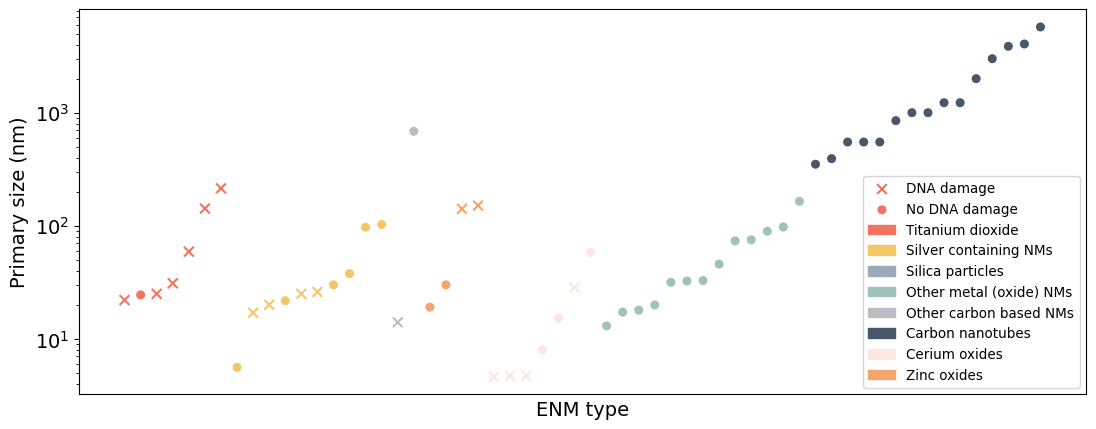

In [28]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import pandas as pd
import numpy as np

plt.figure(figsize=(13,5))

for dna, d in df3.groupby('DNA'):
    label, marker, size = dna.split(',')
    plt.scatter(x=d.index, y=d['Value'],c=d.color,s=int(size), marker=marker, label=label)
    plt.yscale('log',base=10) 
    plt.ylabel("Primary size (nm)")
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) 
    plt.xlabel("ENM type")

# access legend objects automatically created from data
handles, labels = plt.gca().get_legend_handles_labels()

# add legend objects for colors
for kind, color in zipped:
    patch = mpatches.Patch(color=color, label=kind[1:])   
    handles.append(patch)

plt.legend(handles=handles, loc=4, fontsize='x-small')

plt.show()

# Table 4

In [29]:
sparqlquery = '''
PREFIX dcterms: <http://purl.org/dc/terms/>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX obo: <http://purl.obolibrary.org/obo/>
PREFIX aopo: <http://aopkb.org/aop_ontology#>
PREFIX sio: <http://semanticscience.org/resource/>

SELECT DISTINCT ?materialname ?ERM ?ke ?mie ?mietitle ?aop ?aotitle WHERE {
    ?s a obo:CHEBI_59999 ;
        dcterms:identifier ?ERM ;
        dcterms:title ?materialname ;
        sio:SIO_000001 ?ke .
    FILTER (!regex(?materialname, "microparticle|macroparticle", "i"))
    SERVICE <https://aopwiki.rdf.bigcat-bioinformatics.org/sparql> {
        ?aop aopo:has_key_event ?ke ;
            aopo:has_molecular_initiating_event ?mie ;
            aopo:has_adverse_outcome ?ao .
        ?mie dc:title ?mietitle .
        ?ao dc:title ?aotitle .
        FILTER CONTAINS(?mietitle, "DNA")
        }
    }
'''

sparqlendpoint.setQuery(sparqlquery)
sparqlendpoint.setReturnFormat(JSON)  
results = sparqlendpoint.query().convert()

df_mie = pd.DataFrame(columns=["materialname","ERM","ke","mie","mietitle","aop","aotitle"])
for result in results["results"]["bindings"]:
    df_mie.loc[len(df_mie.index)] = [result["materialname"]["value"],
                                     result["ERM"]["value"],
                                     result["ke"]["value"],
                                     result["mie"]["value"],
                                     result["mietitle"]["value"],
                                     result["aop"]["value"],
                                     result["aotitle"]["value"]]

display(df_mie.head(5))


,materialname,ERM,ke,mie,mietitle,aop,aotitle
0,multi-walled carbon nanotubes aerosol,https://nanocommons.github.io/identifiers/regi...,https://identifiers.org/aop.events/1193,https://identifiers.org/aop.events/1194,"Increase, DNA damage",https://identifiers.org/aop/293,"N/A, Breast Cancer"
1,multi-walled carbon nanotubes aerosol,https://nanocommons.github.io/identifiers/regi...,https://identifiers.org/aop.events/1193,https://identifiers.org/aop.events/1194,"Increase, DNA damage",https://identifiers.org/aop/293,"Increased, Ductal Hyperplasia"
2,multi-walled carbon nanotubes aerosol,https://nanocommons.github.io/identifiers/regi...,https://identifiers.org/aop.events/1193,https://identifiers.org/aop.events/1194,"Increase, DNA damage",https://identifiers.org/aop/293,"Increase, Mutations"
3,printex 90 carbon black nanoparticle,https://nanocommons.github.io/identifiers/regi...,https://identifiers.org/aop.events/1766,https://identifiers.org/aop.events/1765,"Increase, Formation of DNA photoproducts",https://identifiers.org/aop/331,"Increase, Mortality"
4,printex 90 carbon black nanoparticle,https://nanocommons.github.io/identifiers/regi...,https://identifiers.org/aop.events/1766,https://identifiers.org/aop.events/1619,"Increase, DNA methyltransferase inhibition",https://identifiers.org/aop/338,"Decrease, Fecundity"


In [30]:
df_mie[df_mie.aotitle.str.contains("Decrease, Population growth rate")]

,materialname,ERM,ke,mie,mietitle,aop,aotitle
6,printex 90 carbon black nanoparticle,https://nanocommons.github.io/identifiers/regi...,https://identifiers.org/aop.events/1766,https://identifiers.org/aop.events/1619,"Increase, DNA methyltransferase inhibition",https://identifiers.org/aop/338,"Decrease, Population growth rate"
7,printex 90 carbon black nanoparticle,https://nanocommons.github.io/identifiers/regi...,https://identifiers.org/aop.events/1766,https://identifiers.org/aop.events/1619,"Increase, DNA methyltransferase inhibition",https://identifiers.org/aop/339,"Decrease, Population growth rate"
11,titanium dioxide nanoparticle,https://nanocommons.github.io/identifiers/regi...,https://identifiers.org/aop.events/1766,https://identifiers.org/aop.events/1619,"Increase, DNA methyltransferase inhibition",https://identifiers.org/aop/338,"Decrease, Population growth rate"
12,titanium dioxide nanoparticle,https://nanocommons.github.io/identifiers/regi...,https://identifiers.org/aop.events/1766,https://identifiers.org/aop.events/1619,"Increase, DNA methyltransferase inhibition",https://identifiers.org/aop/339,"Decrease, Population growth rate"
15,graphene oxide,https://nanocommons.github.io/identifiers/regi...,https://identifiers.org/aop.events/1778,https://identifiers.org/aop.events/1619,"Increase, DNA methyltransferase inhibition",https://identifiers.org/aop/340,"Decrease, Population growth rate"
...,...,...,...,...,...,...,...
263,cerium oxide NM212,https://nanocommons.github.io/identifiers/regi...,https://identifiers.org/aop.events/1766,https://identifiers.org/aop.events/1619,"Increase, DNA methyltransferase inhibition",https://identifiers.org/aop/338,"Decrease, Population growth rate"
264,cerium oxide NM212,https://nanocommons.github.io/identifiers/regi...,https://identifiers.org/aop.events/1766,https://identifiers.org/aop.events/1619,"Increase, DNA methyltransferase inhibition",https://identifiers.org/aop/339,"Decrease, Population growth rate"
268,printex 90 carbon black nanoparticle,https://nanocommons.github.io/identifiers/regi...,https://identifiers.org/aop.events/1194,https://identifiers.org/aop.events/1194,"Increase, DNA damage",https://identifiers.org/aop/444,"Decrease, Population growth rate"
272,zinc oxide nanoparticle NM110,https://nanocommons.github.io/identifiers/regi...,https://identifiers.org/aop.events/1194,https://identifiers.org/aop.events/1194,"Increase, DNA damage",https://identifiers.org/aop/444,"Decrease, Population growth rate"


In [31]:
df_mie.shape

(280, 7)

In [32]:
df_mie.ERM.nunique()

26

In [33]:
df_mie.groupby(["mietitle","aotitle"])["ERM"].nunique()

mietitle                                    aotitle                          
Alkylation, DNA                             Increase, Cancer                      1
                                            Reduce, Sperm count                  18
Increase, DNA damage                        Decrease, Population growth rate     18
                                            Increase, Mutations                  24
                                            Increased, Ductal Hyperplasia        24
                                            N/A, Breast Cancer                   24
Increase, DNA methyltransferase inhibition  Decrease, Fecundity                  19
                                            Decrease, Fecundity (F3)              2
                                            Decrease, Population growth rate     19
Increase, Formation of DNA photoproducts    Increase, Mortality                  18
Increase, Oxidative damage to DNA           Increase, Chromosomal aberrations    1

# Figure 6

In [34]:
df2 = df_mie.copy()
df2['kind'] = 'Other metal (oxide) NMs'

df2.loc[df2[df2.materialname.str.contains('nanotube')].index,'kind'] = 'Carbon nanotubes'
df2.loc[df2[df2.materialname.str.contains('printex|fullerene|graphene')].index,'kind'] = 'Other carbon based NMs'
df2.loc[df2[df2.materialname.str.contains('titanium')].index,'kind'] = 'Titanium dioxide'
df2.loc[df2[df2.materialname.str.contains('silver')].index,'kind'] = 'Silver containing NMs'
df2.loc[df2[df2.materialname.str.contains('silica')].index,'kind'] = 'Silica particles'

df2 = df2.merge(df_c)

display(df2.head(5))

,materialname,ERM,ke,mie,mietitle,aop,aotitle,kind,color
0,multi-walled carbon nanotubes aerosol,https://nanocommons.github.io/identifiers/regi...,https://identifiers.org/aop.events/1193,https://identifiers.org/aop.events/1194,"Increase, DNA damage",https://identifiers.org/aop/293,"N/A, Breast Cancer",Carbon nanotubes,#485868
1,multi-walled carbon nanotubes aerosol,https://nanocommons.github.io/identifiers/regi...,https://identifiers.org/aop.events/1193,https://identifiers.org/aop.events/1194,"Increase, DNA damage",https://identifiers.org/aop/293,"Increased, Ductal Hyperplasia",Carbon nanotubes,#485868
2,multi-walled carbon nanotubes aerosol,https://nanocommons.github.io/identifiers/regi...,https://identifiers.org/aop.events/1193,https://identifiers.org/aop.events/1194,"Increase, DNA damage",https://identifiers.org/aop/293,"Increase, Mutations",Carbon nanotubes,#485868
3,multi-walled carbon nanotubes polyethyleneimine,https://nanocommons.github.io/identifiers/regi...,https://identifiers.org/aop.events/1493,https://identifiers.org/aop.events/1194,"Increase, DNA damage",https://identifiers.org/aop/293,"N/A, Breast Cancer",Carbon nanotubes,#485868
4,multi-walled carbon nanotubes polyethyleneimine,https://nanocommons.github.io/identifiers/regi...,https://identifiers.org/aop.events/1493,https://identifiers.org/aop.events/1194,"Increase, DNA damage",https://identifiers.org/aop/293,"Increased, Ductal Hyperplasia",Carbon nanotubes,#485868


In [35]:
df2.groupby('kind')['ERM'].nunique()

kind
Carbon nanotubes           7
Other carbon based NMs     2
Other metal (oxide) NMs    6
Silver containing NMs      5
Titanium dioxide           6
Name: ERM, dtype: int64

In [36]:
b = pd.DataFrame(df2.groupby(['aotitle','kind','color'])['ERM'].nunique()).reset_index()

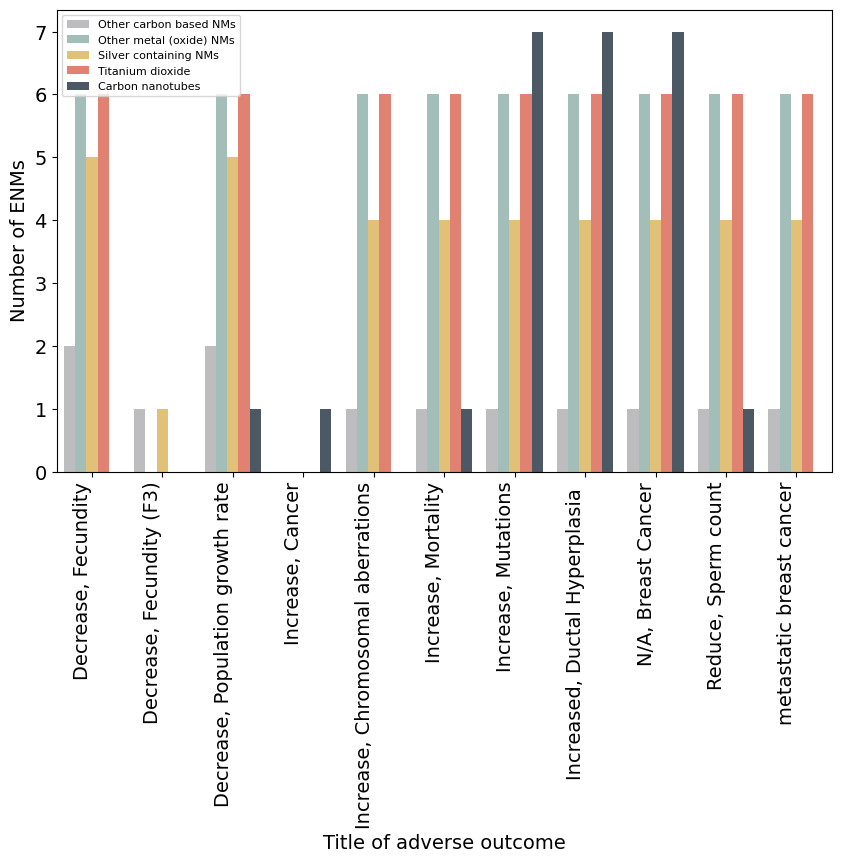

In [37]:
import seaborn as sns

colors2 = ['#bcbdc1', '#9fc2bb', '#f3c766','#f27360', '#485868']
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=b, x="aotitle", y="ERM", hue="kind", palette = colors2, ax=ax)
ax.set_ylabel("Number of ENMs")
ax.set_xlabel("Title of adverse outcome")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
plt.rc('legend', fontsize=8)
plt.legend(loc=2)
plt.show()

# Table S1

In [38]:
sparqlquery = '''
PREFIX dcterms: <http://purl.org/dc/terms/>
PREFIX obo: <http://purl.obolibrary.org/obo/>

select distinct ?ID ?materialname where { 
    ?s a obo:CHEBI_59999; 
    dcterms:identifier ?ID ; 
    dcterms:title ?materialname .
} 
'''

sparqlendpoint.setQuery(sparqlquery)
sparqlendpoint.setReturnFormat(JSON)  
results = sparqlendpoint.query().convert()

df = pd.DataFrame(columns=["ERM","Name"])
for result in results["results"]["bindings"]:
    df.loc[len(df.index)] = [result["ID"]["value"],
                             result["materialname"]["value"]
                            ]

display(df.head(10))

,ERM,Name
0,https://nanocommons.github.io/identifiers/regi...,multi-walled carbon nanotubes
1,https://nanocommons.github.io/identifiers/regi...,erbium oxide nanoparticle
2,https://nanocommons.github.io/identifiers/regi...,Fe3O4 nanoparticle
3,https://nanocommons.github.io/identifiers/regi...,titanium dioxide nanoparticle
4,https://nanocommons.github.io/identifiers/regi...,multi-walled carbon nanotubes aerosol
5,https://nanocommons.github.io/identifiers/regi...,titanium dioxide nanoparticle
6,https://nanocommons.github.io/identifiers/regi...,zinc oxide nanoparticle NM111
7,https://nanocommons.github.io/identifiers/regi...,cerium oxide nanoparticle
8,https://nanocommons.github.io/identifiers/regi...,printex 90 carbon black nanoparticle
9,https://nanocommons.github.io/identifiers/regi...,silica oxide nanoparticle


In [39]:
df.groupby(["Name"])["ERM"].count()

Name
27% zirconium oxide-doped cerium oxide nanoparticle    1
78% zirconium oxide-doped cerium oxide nanoparticle    1
Fe2O3 nanoparticle                                     1
Fe3O4 nanoparticle                                     2
carbon nanotubes                                       1
cerium oxide NM212                                     1
cerium oxide nanoparticle                              4
cobalt oxide nanoparticle                              1
copper macroparticle                                   1
copper nanoparticle                                    2
crystalline silica particles                           1
dysprosium oxide nanoparticle                          1
erbium oxide nanoparticle                              1
europium oxide nanoparticle                            1
fullerene-C60                                          1
gadolinium oxide nanoparticle                          2
gold nanoparticle                                      1
graphene                  

# Table S2

In [40]:
sparqlquery = '''
PREFIX obo: <http://purl.obolibrary.org/obo/>
PREFIX dcterms: <http://purl.org/dc/terms/>
PREFIX bao: <http://www.bioassayontology.org/bao#>
PREFIX sio: <http://semanticscience.org/resource/>

select distinct ?measurement ?methodL (count (distinct ?ID AS ?n)) where {
?s a obo:CHEBI_59999;
dcterms:identifier ?ID ;
dcterms:title ?materialname ; 
obo:BFO_0000056 ?mg .
FILTER (!regex(?materialname, "microparticle|macroparticle", "i"))
?mg bao:BAO_0000208 ?o .
?o a bao:BAO_0000179 ;
rdfs:label ?measurement .
?assay bao:BAO_0000209 ?mg ;
a bao:BAO_0000015 ;
bao:BAO_0002846 ?protocol ;
bao:BAO_0000207 ?method.
?protocol a obo:OBI_0000272 .
?method a bao:BAO_0000035 ;
rdfs:label ?methodL .
}
'''

sparqlendpoint.setQuery(sparqlquery)
sparqlendpoint.setReturnFormat(JSON)  
results = sparqlendpoint.query().convert()

df = pd.DataFrame(columns=["measurement","method","count"])
for result in results["results"]["bindings"]:
    df.loc[len(df.index)] = [result["measurement"]["value"],
                             result["methodL"]["value"],
                             int(result["callret-2"]["value"])
                            ]
display(df.sort_values(by=["measurement"],ascending=True,ignore_index=True))

,measurement,method,count
0,bundle diameter,TEM,8
1,diameter,TEM/AFM,4
2,diameter,UV-Vis,8
3,diameter,TEM,8
4,diameter,TEM/EDS,1
5,hydrodynamic diameter,DLS,36
6,hydrodynamic diameter,photomicrographs,3
7,primary size,TEM,46
8,primary size,TEM/AFM,8
9,primary size,TEM/EDS,1
